# ***1 Import the necessary libraries***

In [1]:
# pip install squarify

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,  roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

import plotly.express as px
import os
import warnings
warnings.filterwarnings("ignore")

# ***2 Load the dataset***


In [3]:
data=pd.read_csv("/content/Telecom Customers Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data=data.set_index('customerID')

In [5]:
#check the data info
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

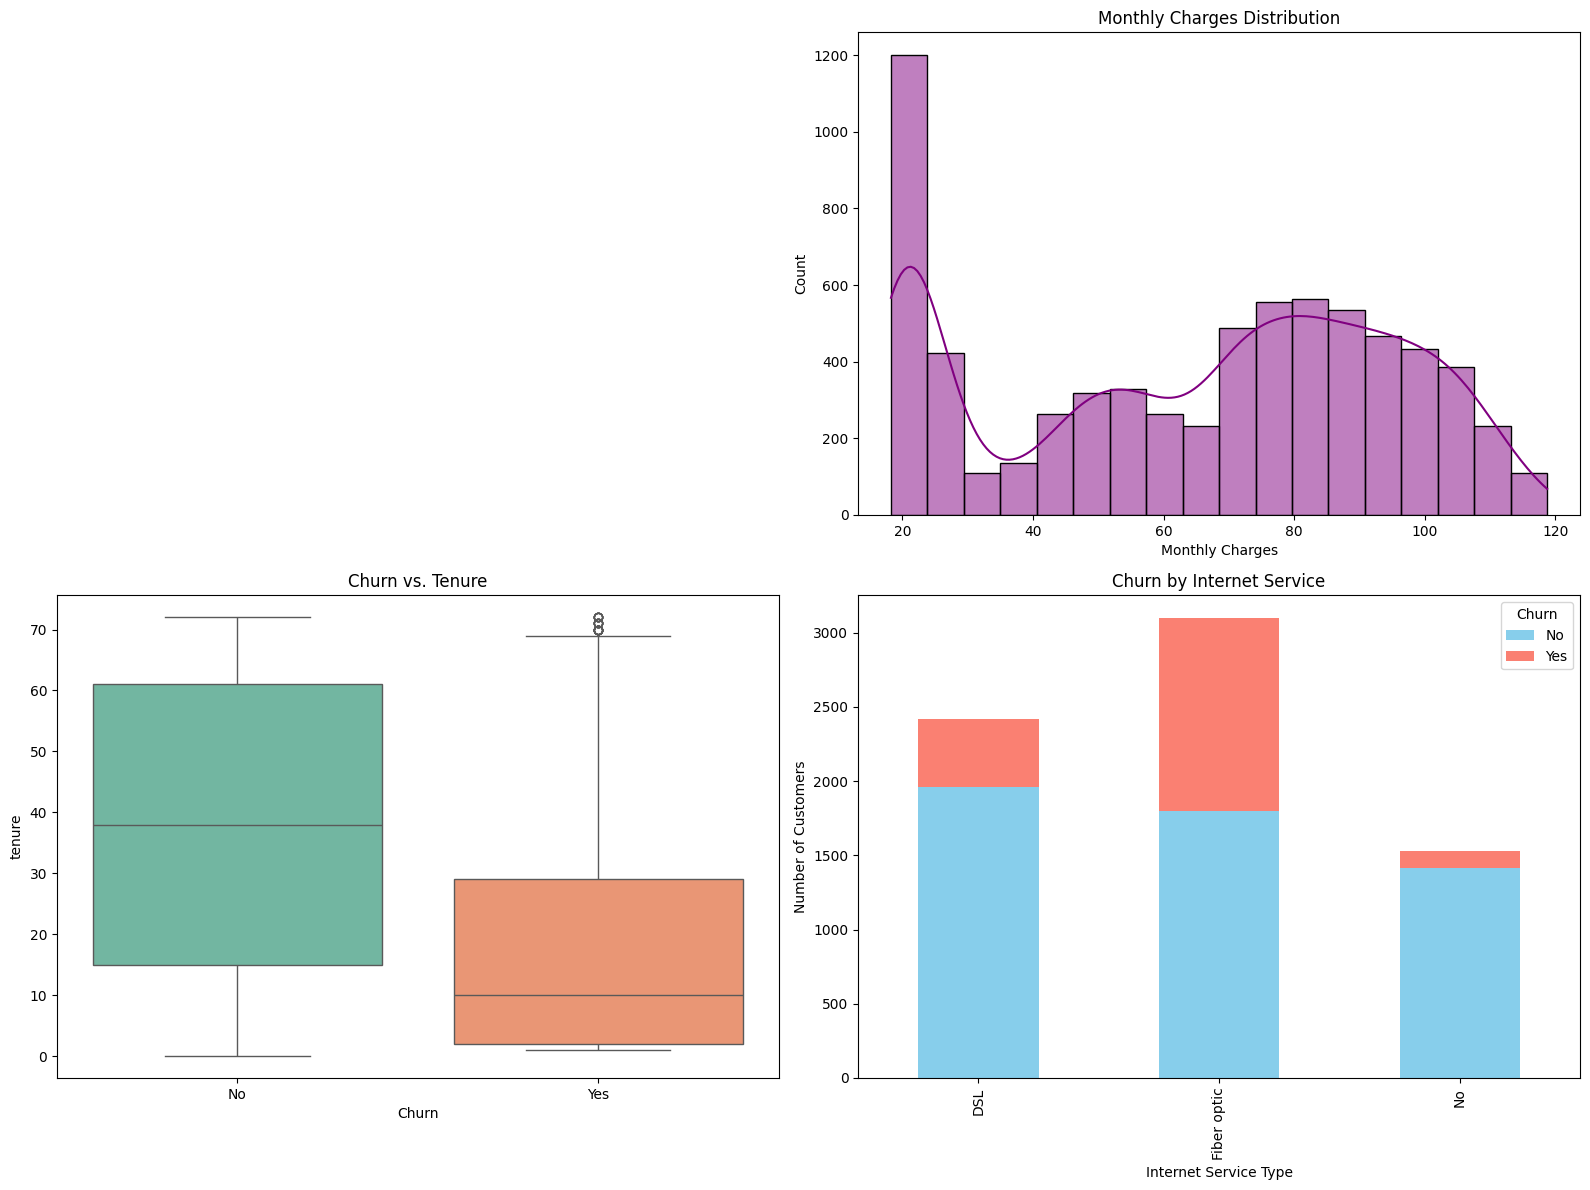

In [6]:
plt.figure(figsize=(16, 12))

# 2. Monthly Charges Distribution (Histogram)
plt.subplot(2, 2, 2)
sns.histplot(data['MonthlyCharges'], kde=True, color='purple')
plt.title('Monthly Charges Distribution')
plt.xlabel('Monthly Charges')

# 3. Churn vs. Tenure (Boxplot)
plt.subplot(2, 2, 3)
sns.boxplot(x='Churn', y='tenure', data=data, palette='Set2')
plt.title('Churn vs. Tenure')

# 4. Churn by Internet Service (Bar Plot)
plt.subplot(2, 2, 4)
internet_service_churn = data.groupby(['InternetService', 'Churn']).size().unstack()
internet_service_churn.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], ax=plt.gca())
plt.title('Churn by Internet Service')
plt.ylabel('Number of Customers')
plt.xlabel('Internet Service Type')

plt.tight_layout()
plt.show()


# ***3 Data Cleaning***



## ***3.0 Define binary and three-value***

In [7]:
binary_columns = []
three_value_columns = []

for col in data.columns:
    unique_values = data[col].nunique()
    if unique_values == 2:
        binary_columns.append(col)
    elif unique_values == 3:
        three_value_columns.append(col)

print("Binary columns:", binary_columns)
print("Three-value columns:", three_value_columns)


Binary columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
Three-value columns: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract']


In [8]:
unique_values = data.apply(lambda x: x.unique()).to_frame()

unique_values

,0
gender,"[Female, Male]"
SeniorCitizen,"[0, 1]"
Partner,"[Yes, No]"
Dependents,"[No, Yes]"
tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ..."
PhoneService,"[No, Yes]"
MultipleLines,"[No phone service, No, Yes]"
InternetService,"[DSL, Fiber optic, No]"
OnlineSecurity,"[No, Yes, No internet service]"
OnlineBackup,"[Yes, No, No internet service]"


In [9]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.fillna(data['TotalCharges'].median(), inplace=True)

# ***3.1 Check duplicates***

In [10]:
data.duplicated().sum()

22

In [11]:
data.drop_duplicates(inplace=True)

In [12]:
data.duplicated().sum()

0

## ***3.2 Encoding Categorical Data***

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
binary_cols = ['PhoneService','gender','Partner','Dependents','PaperlessBilling','Churn']
for col in binary_cols:
    data[col] = label_encoder.fit_transform(data[col])


In [14]:
data = pd.get_dummies(data, columns=['PaymentMethod','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract'], drop_first=True,dtype='int')


## ***3.3 Checking outliers***

In [15]:
num_features= ['tenure', 'MonthlyCharges', 'TotalCharges']
df_num = data[num_features]
df_num.describe()

Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
IQR
((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))).any()

,0
tenure,False
MonthlyCharges,False
TotalCharges,False


In [16]:
unique_values = data.apply(lambda x: x.unique()).to_frame()

unique_values

,0
gender,"[0, 1]"
SeniorCitizen,"[0, 1]"
Partner,"[1, 0]"
Dependents,"[0, 1]"
tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ..."
PhoneService,"[0, 1]"
PaperlessBilling,"[1, 0]"
MonthlyCharges,"[29.85, 56.95, 53.85, 42.3, 70.7, 99.65, 89.1,..."
TotalCharges,"[29.85, 1889.5, 108.15, 1840.75, 151.65, 820.5..."
Churn,"[0, 1]"


In [17]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,0,0
5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,0,...,0,1,0,0,0,0,0,0,1,0
3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,0
7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,0,...,0,1,0,1,0,0,0,0,1,0
9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7021 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7021 non-null   int64  
 1   SeniorCitizen                          7021 non-null   int64  
 2   Partner                                7021 non-null   int64  
 3   Dependents                             7021 non-null   int64  
 4   tenure                                 7021 non-null   int64  
 5   PhoneService                           7021 non-null   int64  
 6   PaperlessBilling                       7021 non-null   int64  
 7   MonthlyCharges                         7021 non-null   float64
 8   TotalCharges                           7021 non-null   float64
 9   Churn                                  7021 non-null   int64  
 10  PaymentMethod_Credit card (automatic)  7021 non-null   int64  

# **4 Create New Feature**

In [19]:
data['EligibleForSubscription'] = (((data['InternetService_Fiber optic'] == 1) | (data['InternetService_No'] == 0)) ).astype(int)

In [20]:
data.head(8)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,EligibleForSubscription
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,0,1
5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,0,0,0,1,0,1
3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,1
7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,1,0,0,0,0,1,0,1
9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,0,1
9305-CDSKC,0,0,0,0,8,1,1,99.65,820.50,1,...,1,0,0,0,1,0,1,0,0,1
1452-KIOVK,1,0,0,1,22,1,1,89.10,1949.40,0,...,0,0,0,0,1,0,0,0,0,1
6713-OKOMC,0,0,0,0,10,0,0,29.75,301.90,0,...,0,0,0,0,0,0,0,0,0,1


# **5 Visualiztion**

In [21]:
# List of categorical columns to plot
categorical_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'PaperlessBilling', 'Churn', 'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
    'MultipleLines_No phone service', 'MultipleLines_Yes',
    'InternetService_Fiber optic', 'InternetService_No',
    'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
    'OnlineBackup_No internet service', 'OnlineBackup_Yes',
    'DeviceProtection_No internet service', 'TechSupport_Yes',
    'StreamingTV_No internet service', 'Contract_One year',
    'Contract_Two year','EligibleForSubscription'
]

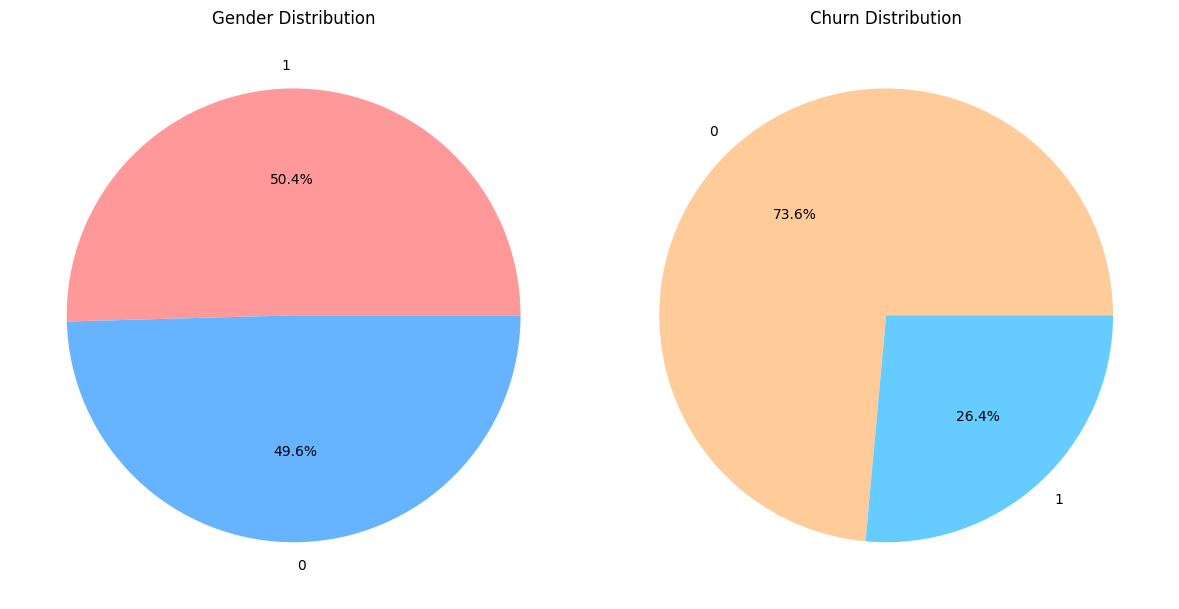

In [22]:
# Set up the subplots for pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for 'gender'
data['gender'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0], colors=['#ff9999','#66b3ff'])
axes[0].set_title('Gender Distribution')
axes[0].set_ylabel('')  # Hide y-label

# Pie chart for 'Churn'
data['Churn'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1], colors=['#ffcc99','#66ccff'])
axes[1].set_title('Churn Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()



In [23]:
# Update the features list to reflect the one-hot encoded columns
features = ['tenure', 'MonthlyCharges', 'Partner', 'Dependents', 'PhoneService',
            'InternetService_Fiber optic', 'InternetService_No']

# Create the scatter matrix plot with the updated features
fig = px.scatter_matrix(data, dimensions=features, color='Churn',
                        title='Scatter Matrix of Customer Features',
                        labels={col: col for col in features})

# Show the plot
fig.show()


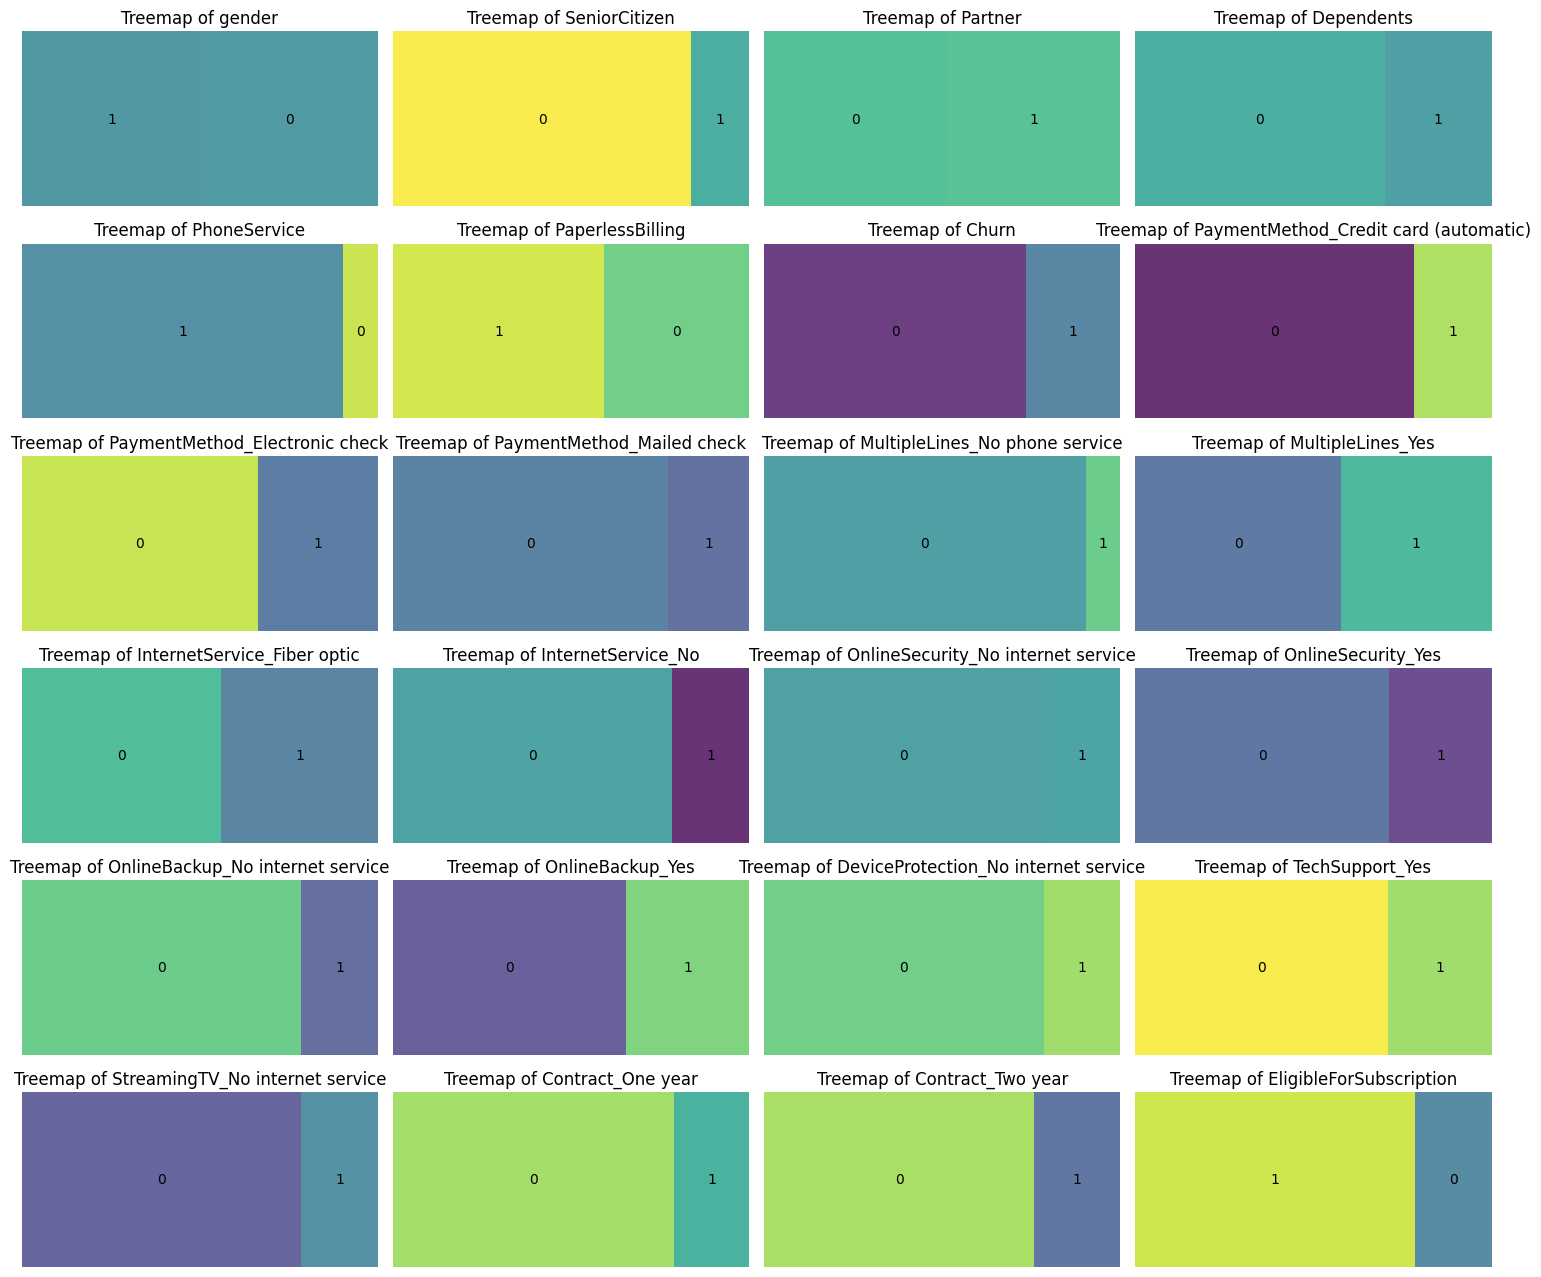

In [24]:
import matplotlib.pyplot as plt
import squarify




plt.figure(figsize=(15, 15))
# Create treemaps for all categorical variables
for i, var in enumerate(categorical_cols):
    plt.subplot(7, 4, i + 1)
    sizes = data[var].value_counts().values
    labels = data[var].value_counts().index
    squarify.plot(sizes=sizes, label=labels, alpha=.8)
    plt.title(f'Treemap of {var}')
    plt.axis('off')

plt.tight_layout()
plt.show()




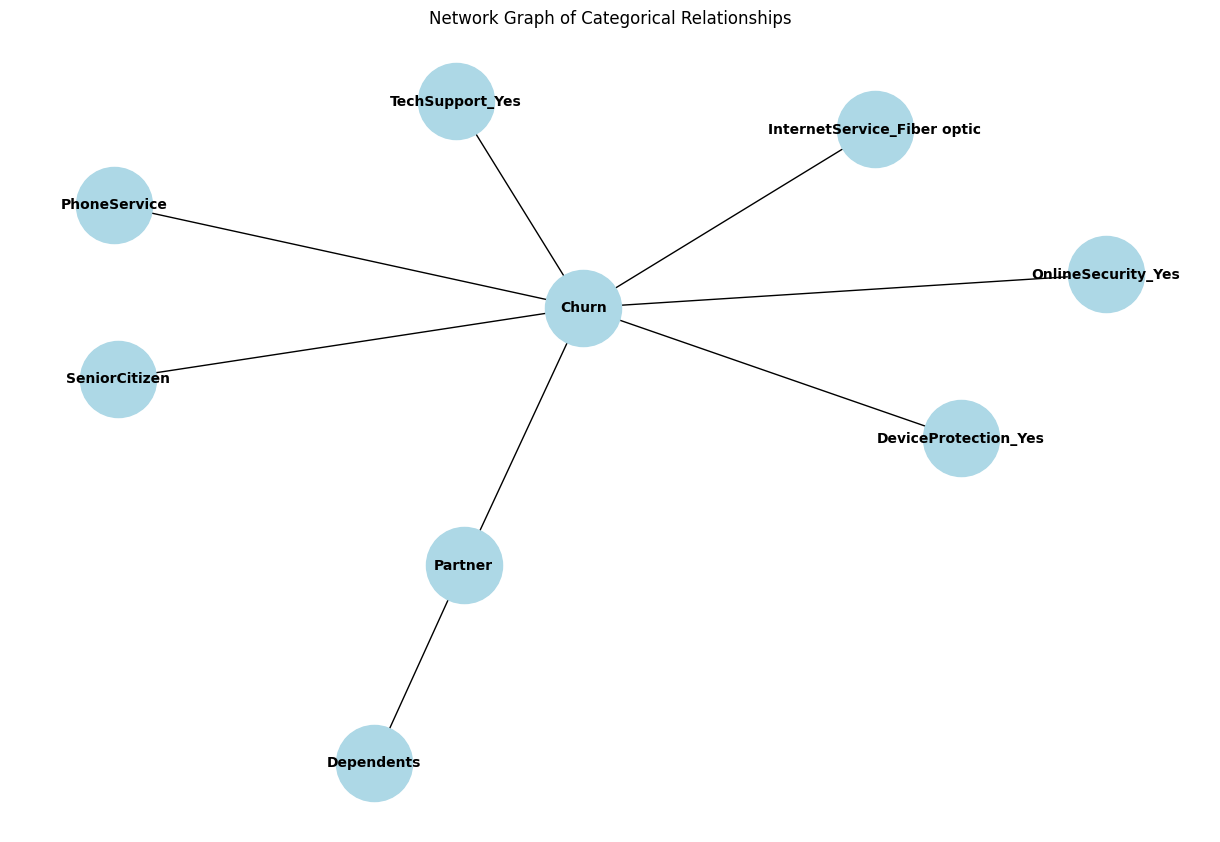

In [25]:
import networkx as nx

# Create a network graph for categorical relationships
G = nx.Graph()

# Define relationships based on your data
edges = [
    ('Churn', 'Partner'),
    ('Churn', 'SeniorCitizen'),
    ('Partner', 'Dependents'),
    ('PhoneService', 'Churn'),
    ('InternetService_Fiber optic', 'Churn'),
    ('OnlineSecurity_Yes', 'Churn'),
    ('DeviceProtection_Yes', 'Churn'),
    ('TechSupport_Yes', 'Churn'),
]

G.add_edges_from(edges)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
plt.title('Network Graph of Categorical Relationships')
plt.show()


array([[<Axes: title={'center': 'MonthlyCharges'}>,
        <Axes: title={'center': 'TotalCharges'}>],
       [<Axes: title={'center': 'tenure'}>, <Axes: >]], dtype=object)

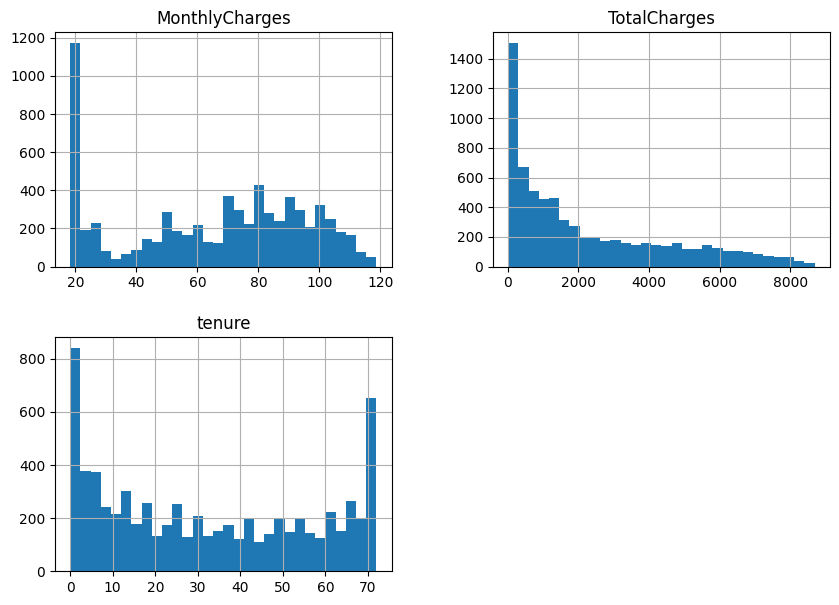

In [26]:
data[['MonthlyCharges', 'TotalCharges', 'tenure']].hist(bins=30, figsize=(10,7))

In [27]:

corr_matrix = data[['gender','PhoneService','PaperlessBilling','gender', 'SeniorCitizen','tenure', 'MonthlyCharges',  'Partner', 'Dependents','TotalCharges','Churn','MultipleLines_No phone service', 'MultipleLines_Yes']].corr()
fi = px.imshow(corr_matrix, text_auto=True, color_continuous_scale='Viridis',
                title='Heatmap of Feature Correlations')

fi.show()

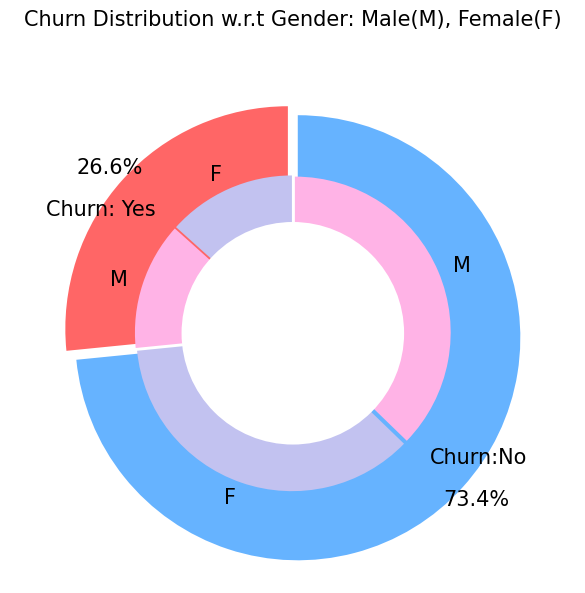

In [28]:
plt.figure(figsize=(6, 6))
labels =["Churn: Yes","Churn:No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot

plt.axis('equal')
plt.tight_layout()
plt.show()

<Axes: xlabel='Churn'>

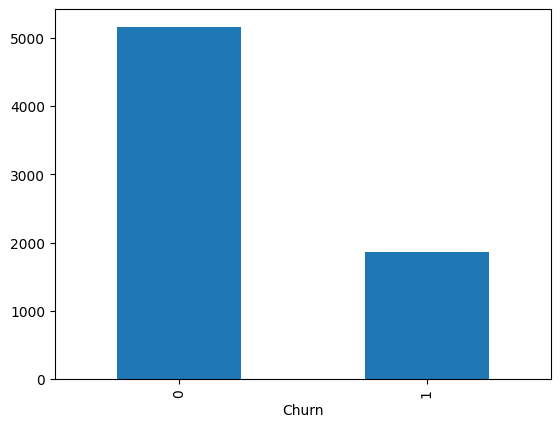

In [29]:
data['Churn'].value_counts().plot(kind='bar')


<Axes: xlabel='gender'>

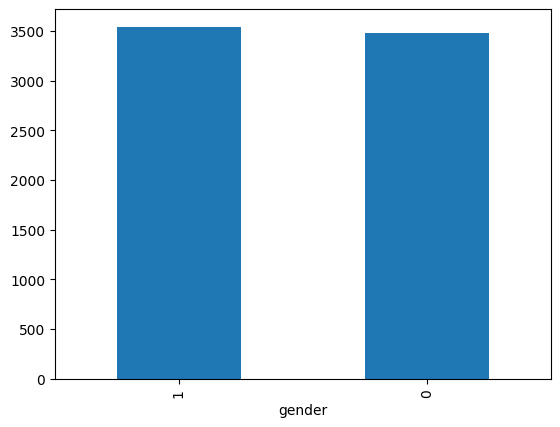

In [30]:
data['gender'].value_counts().plot(kind='bar')

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

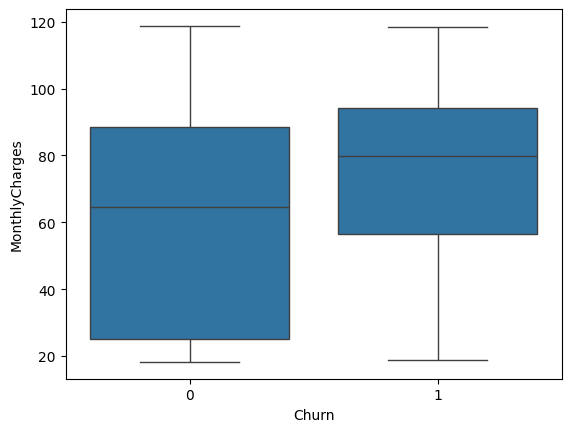

In [31]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=data)

# **6 Exploratory Data Analysis (EDA)**

### ***6.1 Univariate Analysis***

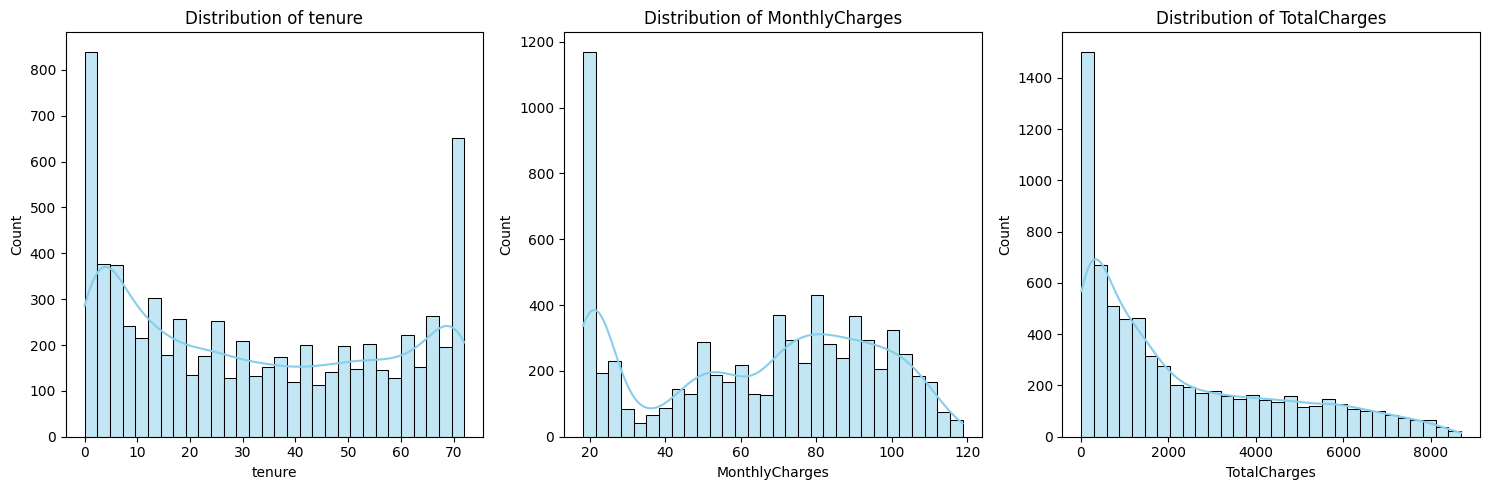

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = [
    'tenure', 'MonthlyCharges', 'TotalCharges'
]

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    sns.histplot(data[col], kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


## ***6.2 Categorical Data Analysis***


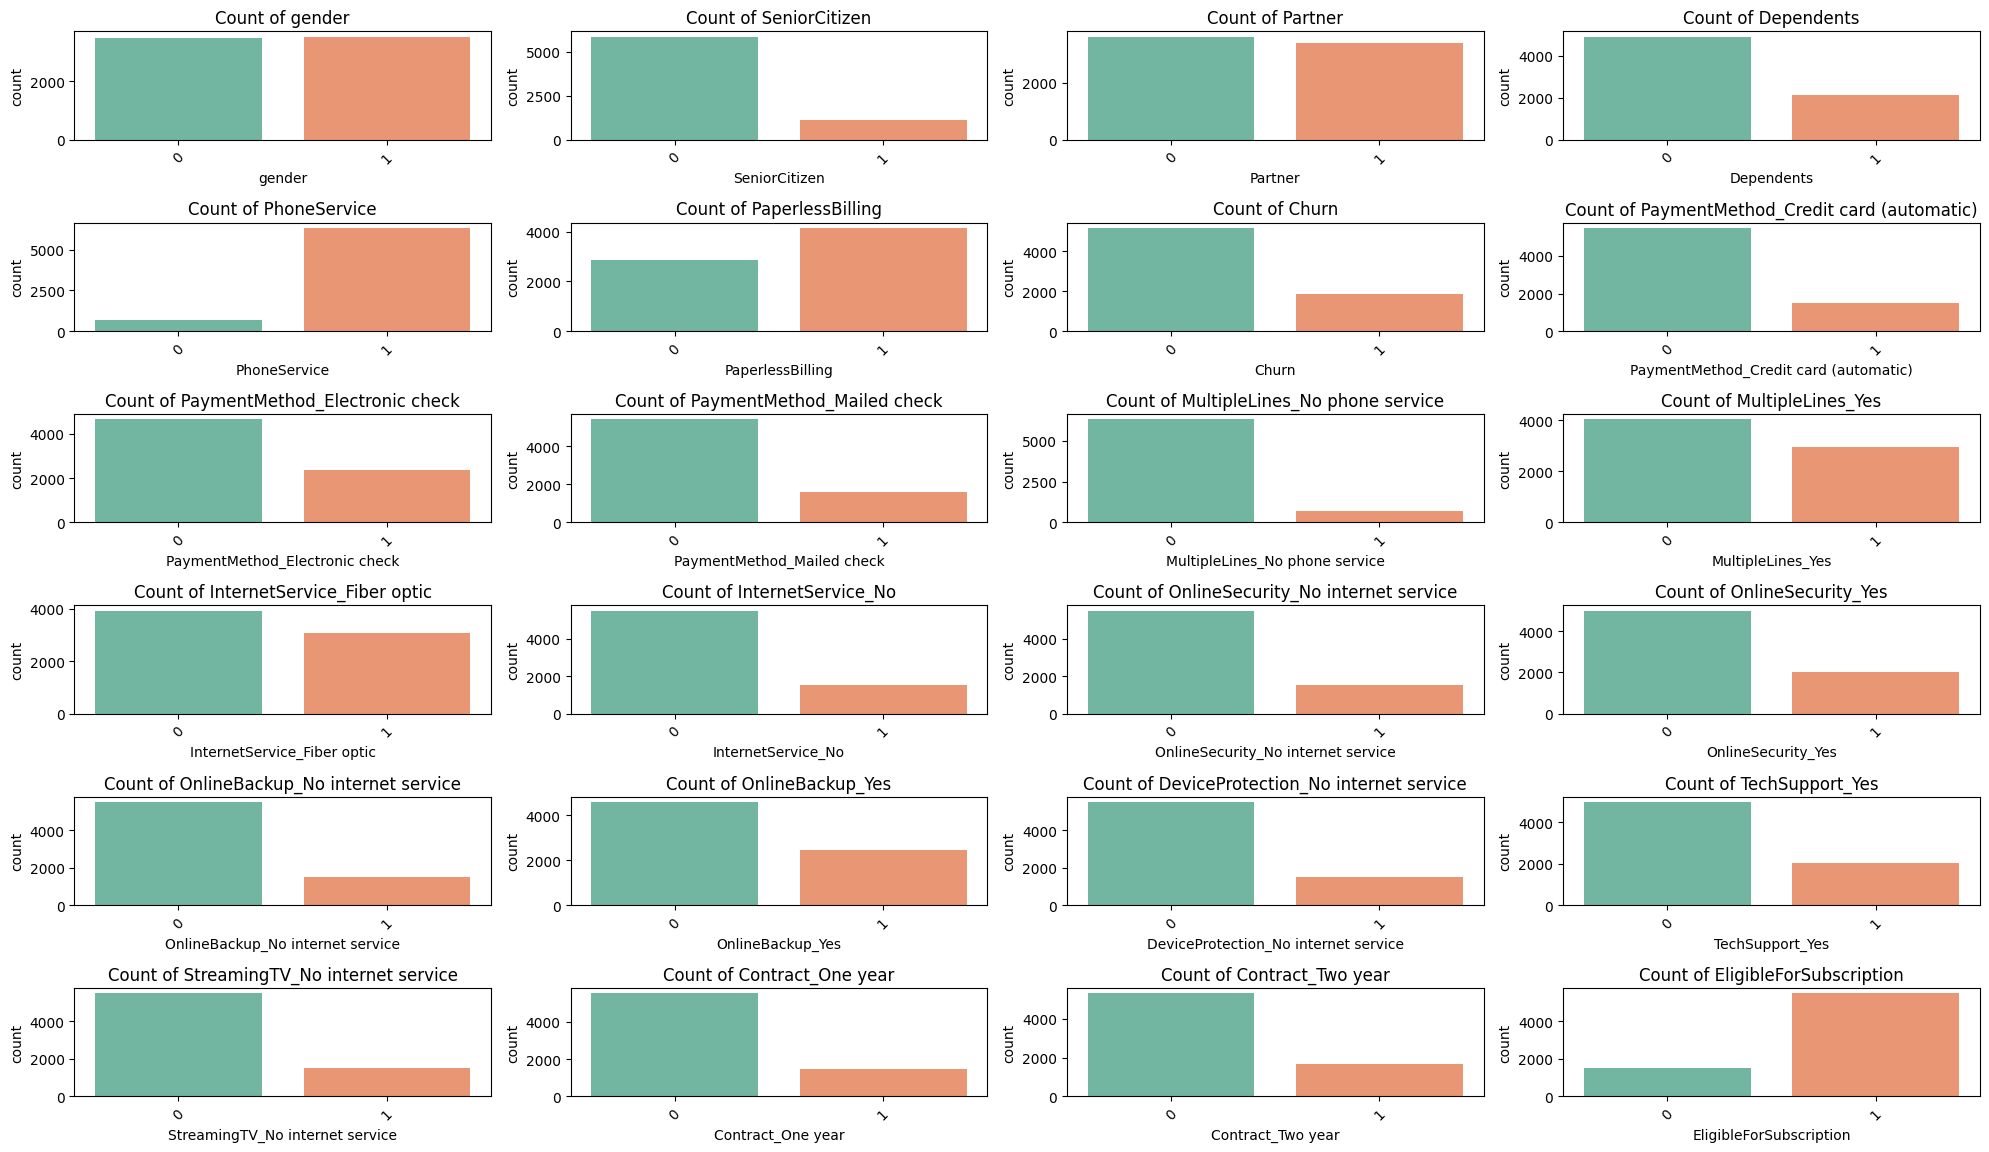

In [33]:
# 2 Categorical Data Analysis¶
plt.figure(figsize=(20, 15))

for i, col in enumerate(categorical_cols):
    plt.subplot(8, 4, i + 1)
    sns.countplot(x=col, data=data, palette='Set2')
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



## ***6.3 bivariate analysis***

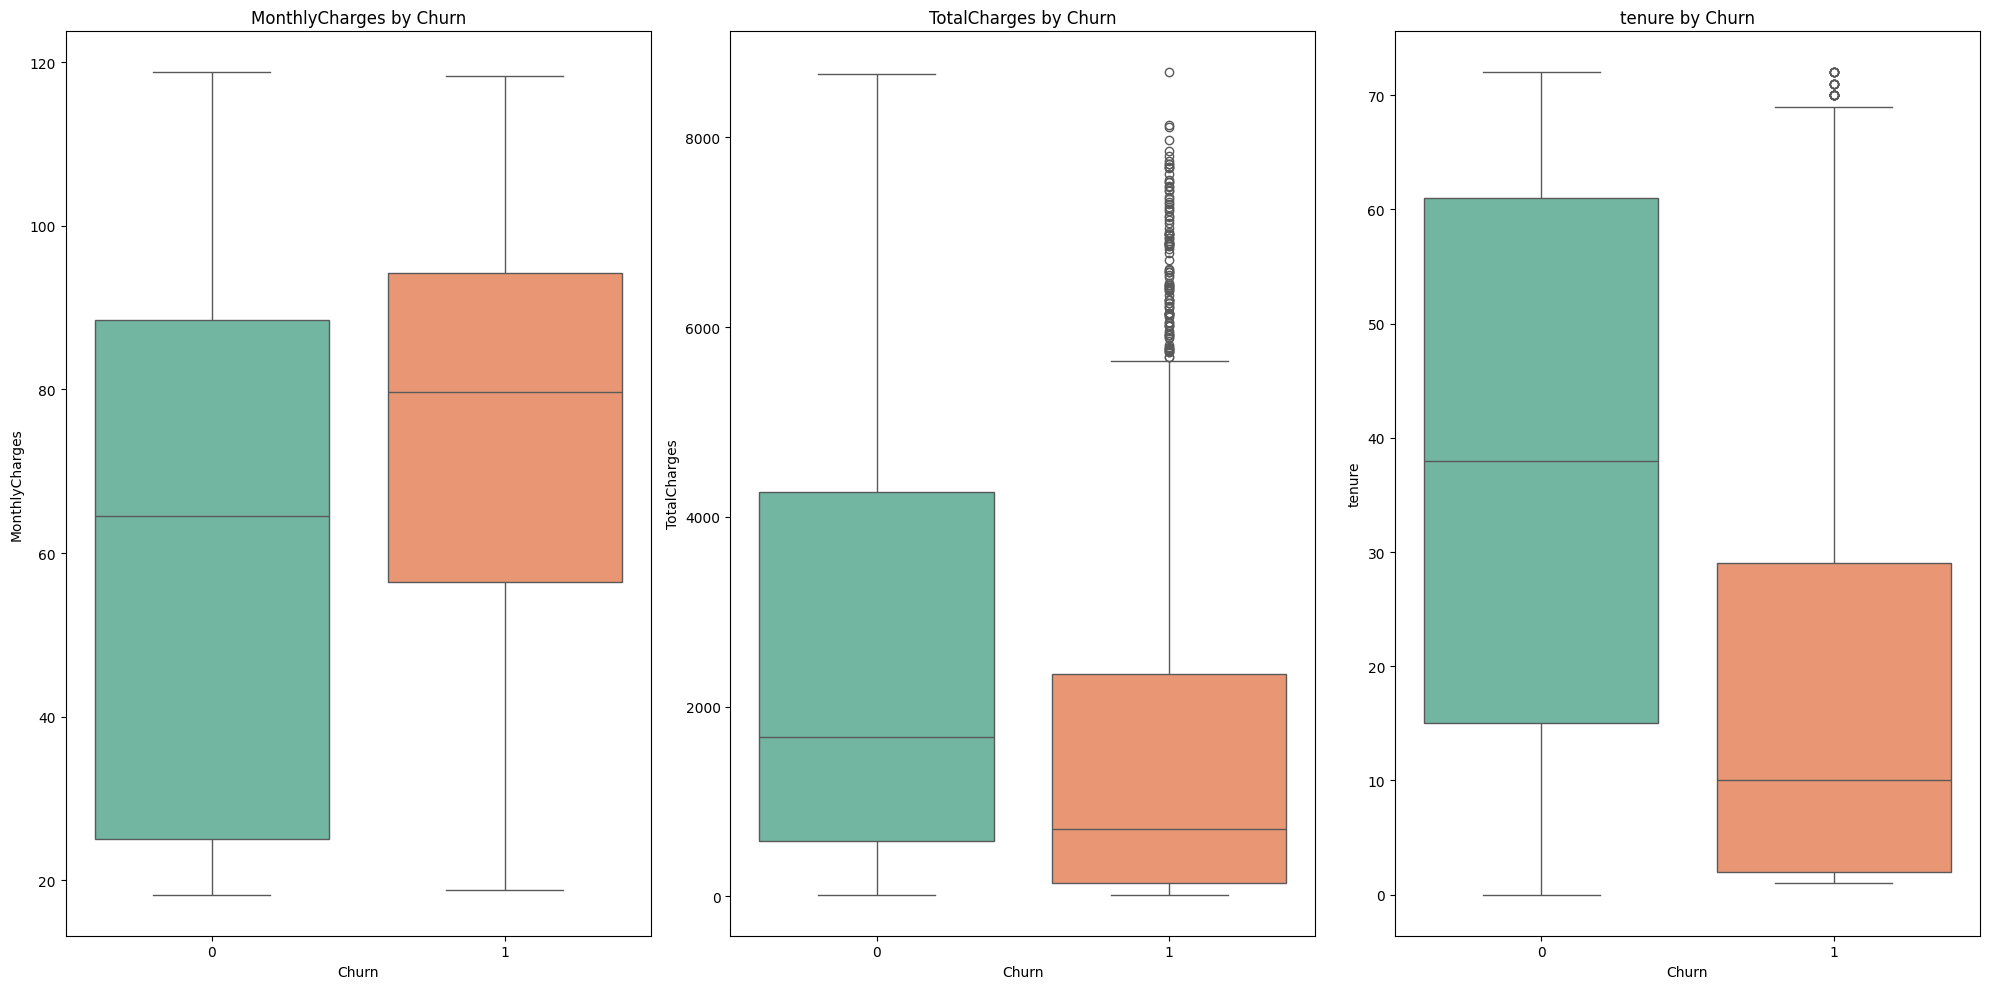

In [34]:
#bivariate analysis
numerical_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']

plt.figure(figsize=(20, 10))
for i, num_col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    sns.boxplot(x='Churn', y=num_col, data=data, palette='Set2')
    plt.title(f'{num_col} by Churn')

plt.tight_layout()
plt.show()


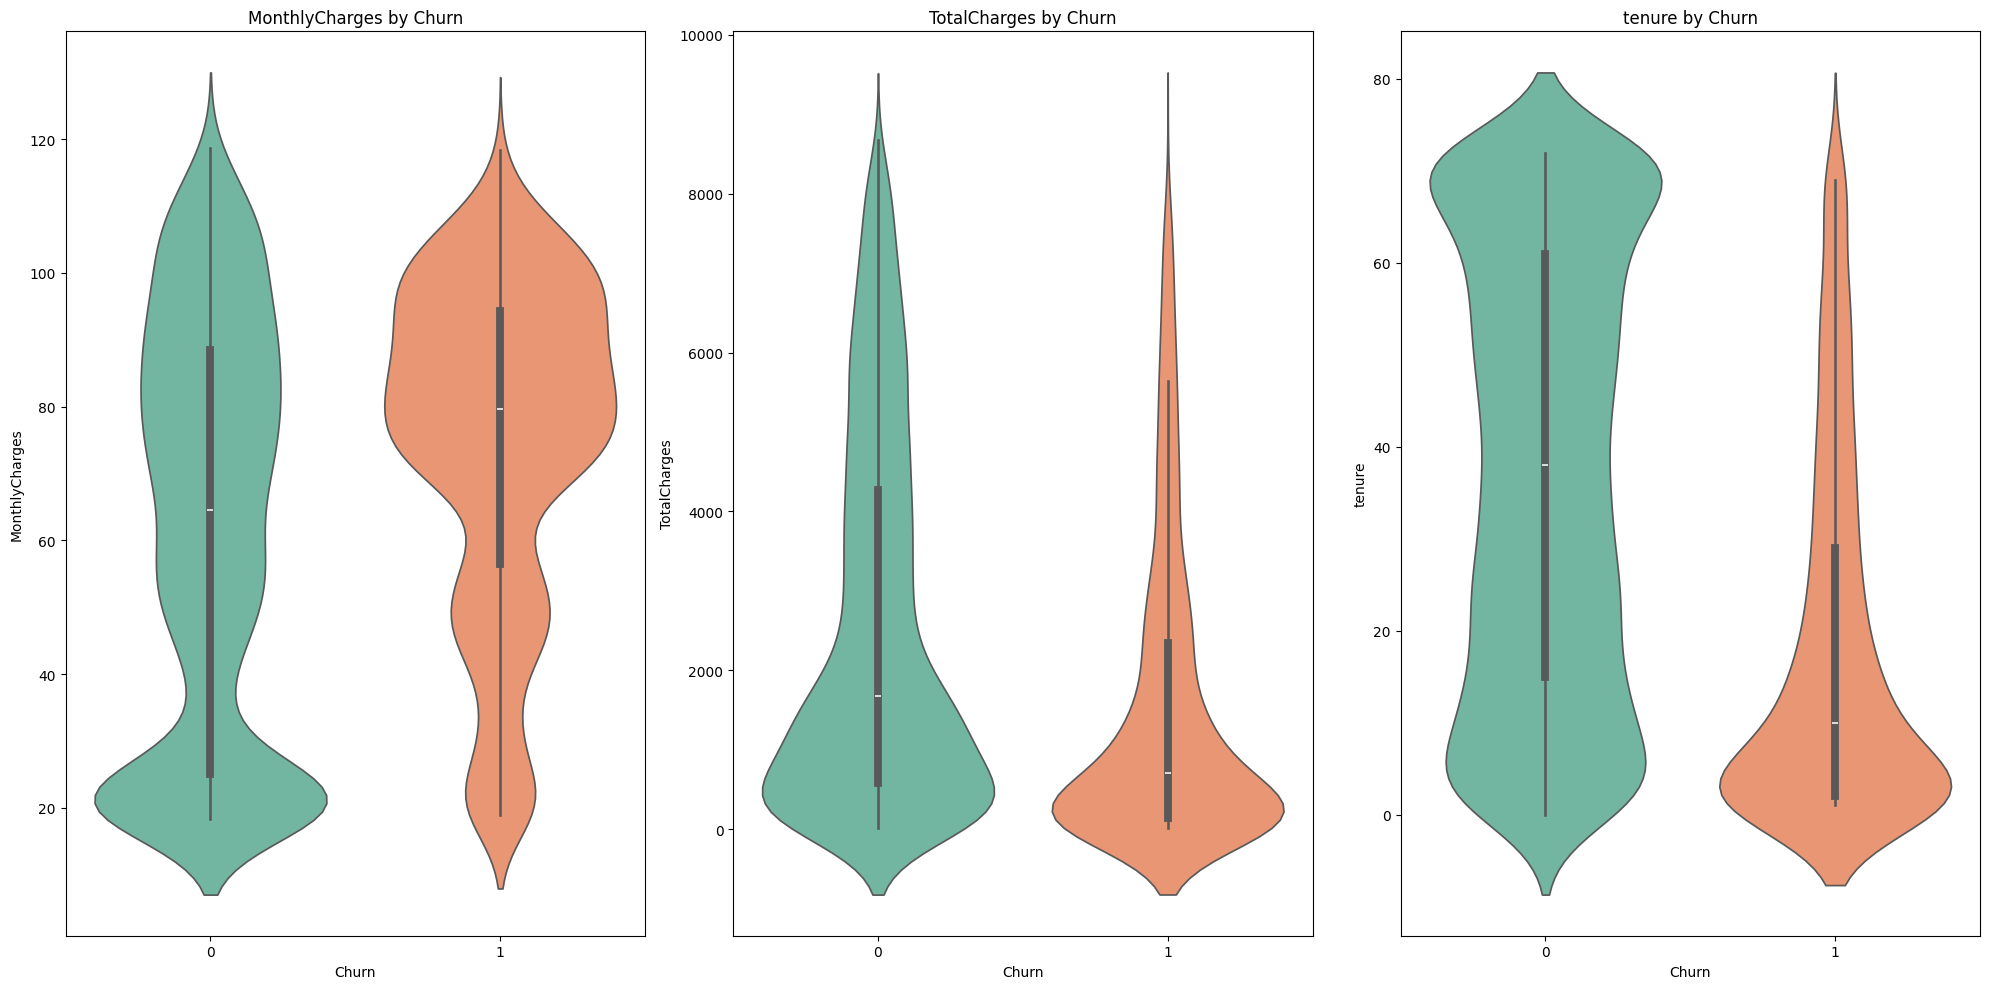

In [35]:
# Violin Plots
plt.figure(figsize=(20, 10))

for i, num_col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    sns.violinplot(x='Churn', y=num_col, data=data, palette='Set2')
    plt.title(f'{num_col} by Churn')

plt.tight_layout()
plt.show()


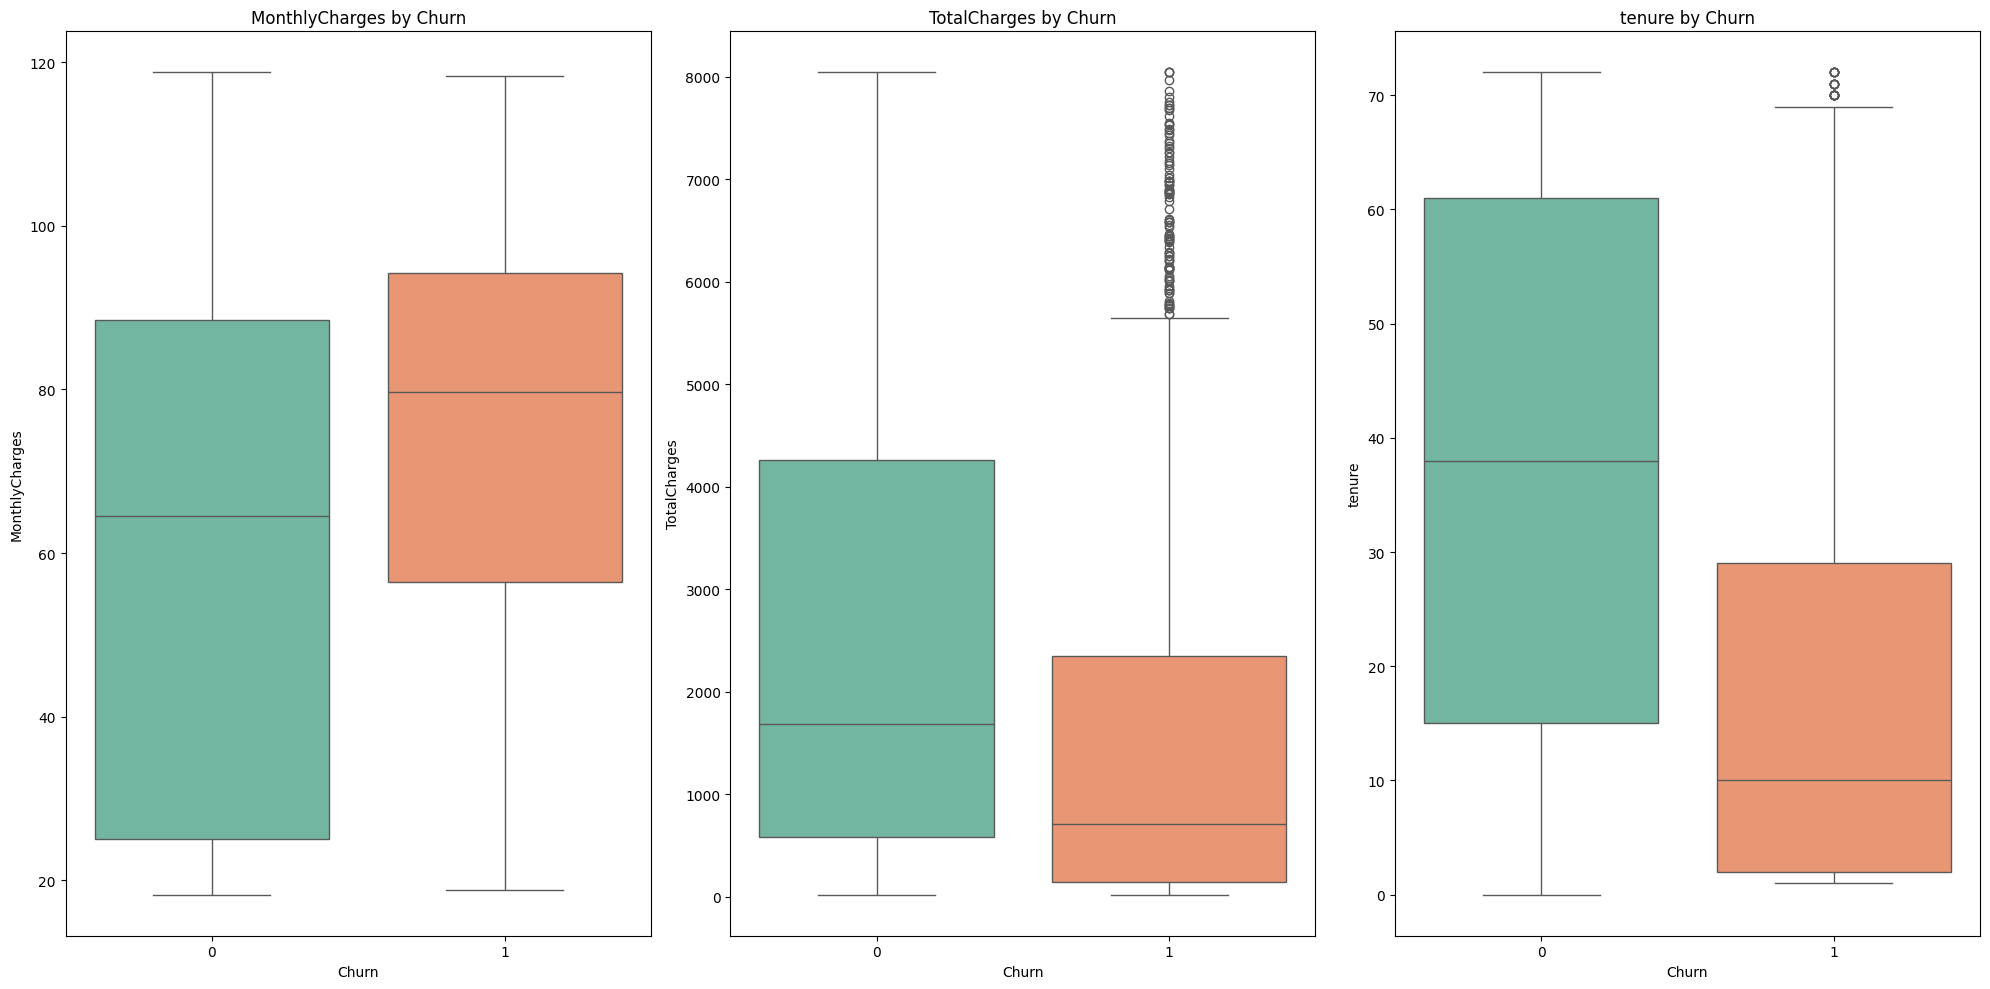

In [36]:
# Cap the values at the 1st and 99th percentiles
lower_bound = data['TotalCharges'].quantile(0.01)
upper_bound = data['TotalCharges'].quantile(0.99)

# Apply capping
data['TotalCharges'] = data['TotalCharges'].clip(lower=lower_bound, upper=upper_bound)




#bivariate analysis
numerical_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']

plt.figure(figsize=(20, 10))
for i, num_col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    sns.boxplot(x='Churn', y=num_col, data=data, palette='Set2')
    plt.title(f'{num_col} by Churn')

plt.tight_layout()
plt.show()


# **7. Modeling**

## ***7.1 Spliting Data***

In [37]:
X=data.drop('Churn',axis=1)
y=data['Churn']
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

## ***7.2 Handling Class Imbalance and Feature Scaling***

In [38]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTEN
from imblearn.combine import SMOTETomek

# Apply SMOTEN
smoten = SMOTEN(random_state=42)
X_train_resampled, y_train_resampled = smoten.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

## ***7.3 Building and Implementing Machine Learning Models***

# **RandomForestClassifier**

In [39]:
rf_model = RandomForestClassifier(n_estimators=40, max_depth=10, min_samples_split=70, random_state=42)
rf_model.fit(X_train_scaled, y_train_resampled)

# Make predictions and evaluate for Random Forest
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)
y_test_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
# Evaluate performance for Random Forest
train_accuracy_rf = accuracy_score(y_train_resampled, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_test_prob_rf)
print(f"Random Forest Training accuracy: {train_accuracy_rf:.4f}")
print(f"Random Forest Test accuracy: {test_accuracy_rf:.4f}")
print("Random Forest Test Set Classification Report:")
print(classification_report(y_test, y_test_pred_rf))
print(f"Random Forest ROC-AUC: {roc_auc_rf:.4f}")

Random Forest Training accuracy: 0.8434
Random Forest Test accuracy: 0.7874
Random Forest Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1556
           1       0.58      0.68      0.63       551

    accuracy                           0.79      2107
   macro avg       0.73      0.75      0.74      2107
weighted avg       0.80      0.79      0.79      2107

Random Forest ROC-AUC: 0.8431


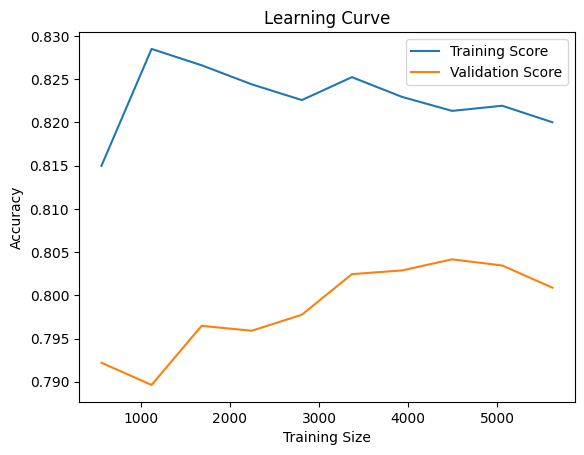

In [40]:
train_sizes, train_scores, test_scores = learning_curve(rf_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

ROC-AUC Score: 0.8431334241551933


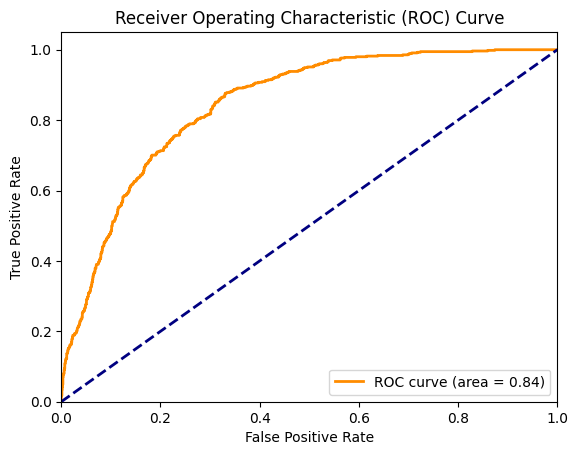

In [41]:
y_test_prob_rf_model = rf_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob_rf_model)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **LogisticRegression**

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
clf = LogisticRegression(penalty='l2', C=1.0, random_state=42)
clf.fit(X_train_scaled, y_train_resampled)

# Make predictions and evaluate for Logistic Regression
y_train_pred_logreg = clf.predict(X_train_scaled)
y_test_pred_logreg = clf.predict(X_test_scaled)
y_test_prob_logreg = clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance for Logistic Regression
train_accuracy_logreg = accuracy_score(y_train_resampled, y_train_pred_logreg)
test_accuracy_logreg = accuracy_score(y_test, y_test_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_test_prob_logreg)

print(f"Logistic Regression Training accuracy: {train_accuracy_logreg:.4f}")
print(f"Logistic Regression Test accuracy: {test_accuracy_logreg:.4f}")
print("Logistic Regression Test Set Classification Report:")
print(classification_report(y_test, y_test_pred_logreg))
print(f"Logistic Regression ROC-AUC: {roc_auc_logreg:.4f}")


Logistic Regression Training accuracy: 0.8234
Logistic Regression Test accuracy: 0.7879
Logistic Regression Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1556
           1       0.58      0.70      0.63       551

    accuracy                           0.79      2107
   macro avg       0.73      0.76      0.74      2107
weighted avg       0.80      0.79      0.79      2107

Logistic Regression ROC-AUC: 0.8415


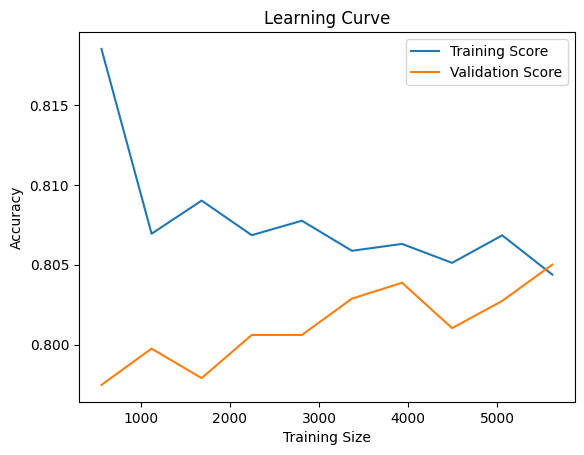

In [43]:
train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

ROC-AUC Score: 0.8415133270193479


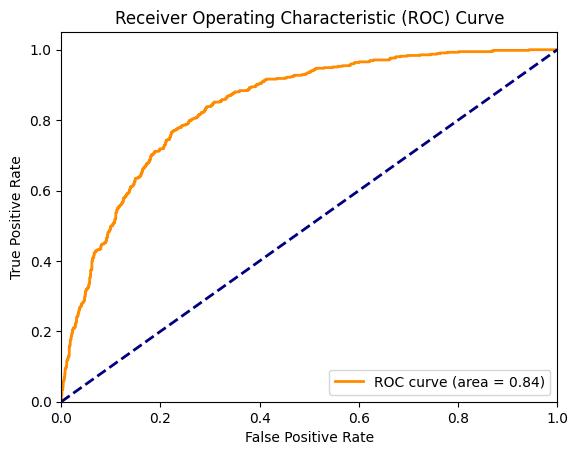

In [44]:
y_test_prob_clf = clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob_clf)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **DecisionTreeClassifier**

In [45]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=6, random_state=42)
dtc.fit(X_train_scaled, y_train_resampled)

y_train_pred_dtc = clf.predict(X_train_scaled)
y_test_pred_dtc = clf.predict(X_test_scaled)
y_test_prob_dtc = dtc.predict_proba(X_test_scaled)[:, 1]

train_accuracy_dtc = accuracy_score(y_train_resampled, y_train_pred_dtc)
test_accuracy_dtc = accuracy_score(y_test, y_test_pred_dtc)
roc_auc_dtc = roc_auc_score(y_test, y_test_prob_dtc)

print(f"DecisionTreeClassifier Training accuracy: {train_accuracy_dtc:.4f}")
print(f"DecisionTreeClassifier Test accuracy: {test_accuracy_dtc:.4f}")
print("DecisionTreeClassifier Test Set Classification Report:")
print(classification_report(y_test, y_test_pred_dtc))

print(f"DecisionTreeClassifier ROC-AUC: {roc_auc_dtc:.4f}")


DecisionTreeClassifier Training accuracy: 0.8234
DecisionTreeClassifier Test accuracy: 0.7879
DecisionTreeClassifier Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1556
           1       0.58      0.70      0.63       551

    accuracy                           0.79      2107
   macro avg       0.73      0.76      0.74      2107
weighted avg       0.80      0.79      0.79      2107

DecisionTreeClassifier ROC-AUC: 0.8174


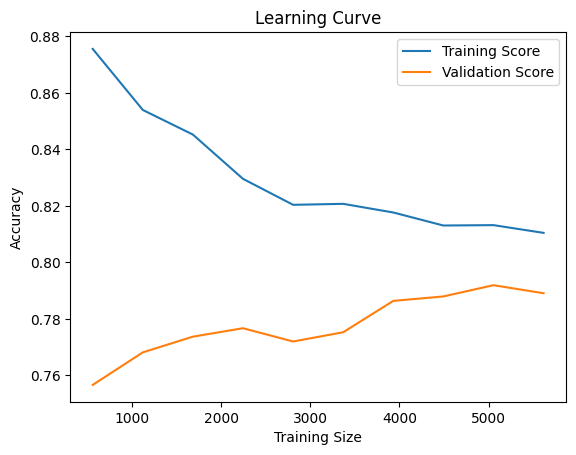

In [46]:
train_sizes, train_scores, test_scores = learning_curve(dtc, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

ROC-AUC Score: 0.8173506688003581


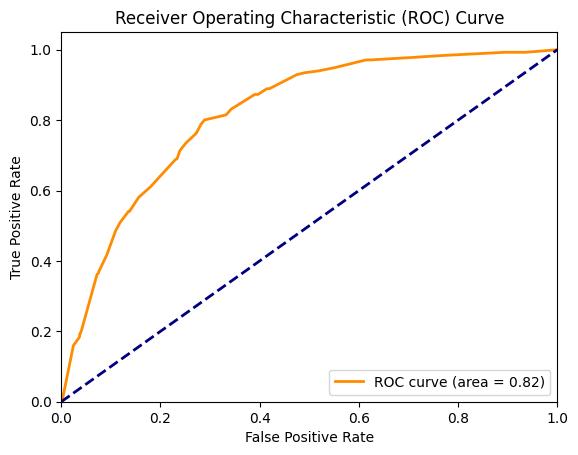

In [47]:
y_test_prob_dtc = dtc.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob_dtc)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **XGBoost Classifier**

In [48]:
# XGBoost Classifier
xgb_model = XGBClassifier(
       max_depth=4,
    min_child_weight=8,
    gamma=1,
    n_estimators=1000,
    eval_metric='mlogloss'
)

# Train with early stopping
xgb_model.fit(X_train_scaled, y_train_resampled)
y_test_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Make predictions and evaluate for XGBoost
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate performance for XGBoost
train_accuracy_xgb = accuracy_score(y_train_resampled, y_train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_test_prob_xgb)

print(f"XGBoost Training accuracy: {train_accuracy_xgb:.4f}")
print(f"XGBoost Test accuracy: {test_accuracy_xgb:.4f}")
print("XGBoost Test Set Classification Report:")
print(classification_report(y_test, y_test_pred_xgb))
print(f"XGBoost ROC-AUC: {roc_auc_xgb:.4f}")


XGBoost Training accuracy: 0.8740
XGBoost Test accuracy: 0.7803
XGBoost Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1556
           1       0.57      0.64      0.60       551

    accuracy                           0.78      2107
   macro avg       0.72      0.73      0.73      2107
weighted avg       0.79      0.78      0.78      2107

XGBoost ROC-AUC: 0.8282


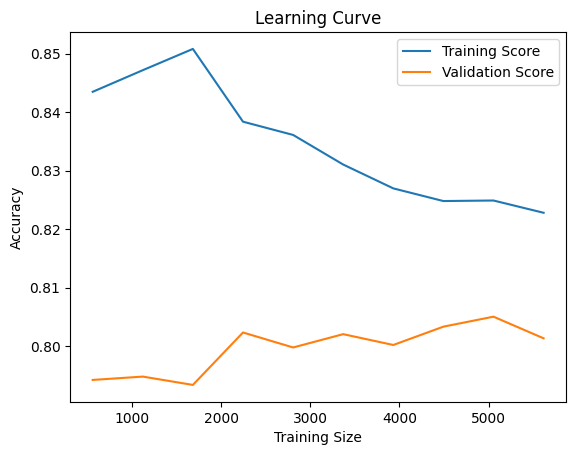

In [49]:
train_sizes, train_scores, test_scores = learning_curve(xgb_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

ROC-AUC Score: 0.8281839749182371


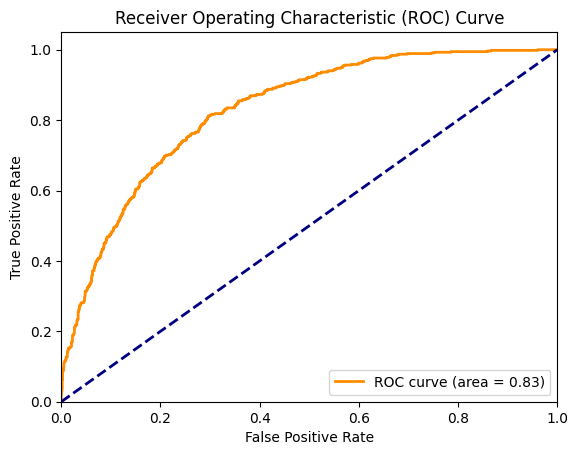

In [80]:
y_test_prob_dtc = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob_dtc)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **SVC**

In [51]:
from sklearn.svm import SVC

SVC_model = SVC(kernel='linear', C=1.0, gamma=1, random_state=42 ,cache_size=1000)

SVC_model.fit(X_train_scaled, y_train_resampled)

y_train_pred_SVC = SVC_model.predict(X_train_scaled)
y_test_pred_SVC = SVC_model.predict(X_test_scaled)
y_test_prob_svc = SVC_model.decision_function(X_test_scaled)

train_accuracy_SVC = accuracy_score(y_train_resampled, y_train_pred_SVC)
test_accuracy_SVC = accuracy_score(y_test, y_test_pred_SVC)
roc_auc_svc = roc_auc_score(y_test, y_test_prob_svc)

print(f"SVC Training accuracy: {train_accuracy_SVC:.4f}")
print(f"SVC Test accuracy: {test_accuracy_SVC:.4f}")
print("SVC Test Set Classification Report:")
print(classification_report(y_test, y_test_pred_SVC))
print(f"SVC ROC-AUC: {roc_auc_svc:.4f}")


SVC Training accuracy: 0.8261
SVC Test accuracy: 0.7869
SVC Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1556
           1       0.58      0.67      0.62       551

    accuracy                           0.79      2107
   macro avg       0.73      0.75      0.74      2107
weighted avg       0.80      0.79      0.79      2107

SVC ROC-AUC: 0.8346


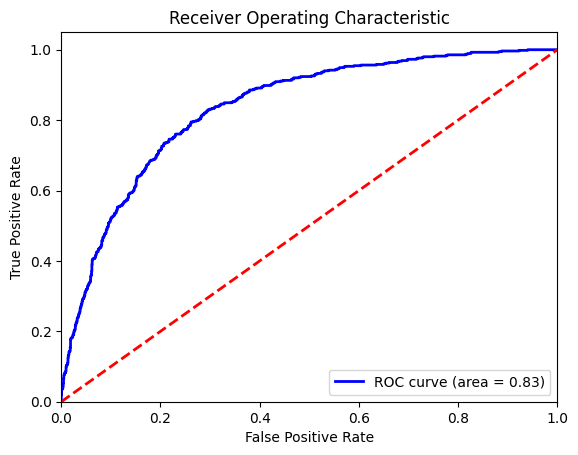

In [52]:
SVC_model = SVC(kernel='linear', C=1.0, gamma=1, random_state=42,probability=True)
SVC_model.fit(X_train_scaled, y_train_resampled)
y_probs = SVC_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _= roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# **KNeighborsClassifier**

In [53]:
from sklearn.neighbors import KNeighborsClassifier


KNN = KNeighborsClassifier(n_neighbors=8,leaf_size=10,algorithm="auto",weights='uniform')


KNN.fit(X_train_scaled, y_train_resampled)

y_train_pred_knn = KNN.predict(X_train_scaled)
y_test_pred_knn = KNN.predict(X_test_scaled)
y_test_prob_knn = KNN.predict_proba(X_test_scaled)[:, 1]

train_accuracy_knn = accuracy_score(y_train_resampled, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_test_prob_knn)

print(f"Training Accuracy: {train_accuracy_knn:.4f}")
print(f"Test Accuracy: {test_accuracy_knn:.4f}")
print("KNN Test Set Classification Report:")
print(classification_report(y_test, y_test_pred_knn))
print(f"KNN ROC-AUC: {roc_auc_knn:.4f}")



Training Accuracy: 0.8585
Test Accuracy: 0.7537
KNN Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1556
           1       0.52      0.64      0.57       551

    accuracy                           0.75      2107
   macro avg       0.69      0.72      0.70      2107
weighted avg       0.77      0.75      0.76      2107

KNN ROC-AUC: 0.7895


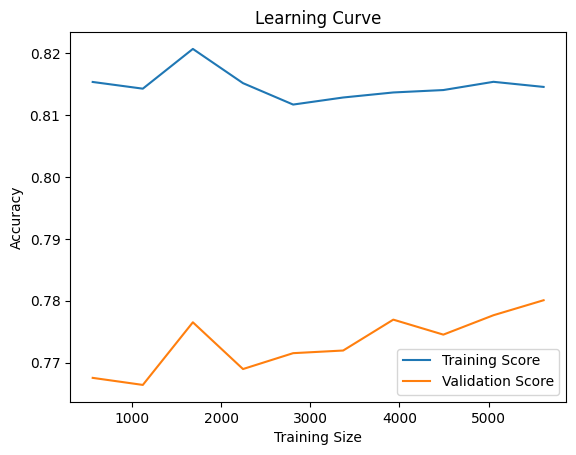

In [54]:
train_sizes, train_scores, test_scores = learning_curve(KNN, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

ROC-AUC Score: 0.7894608540676218


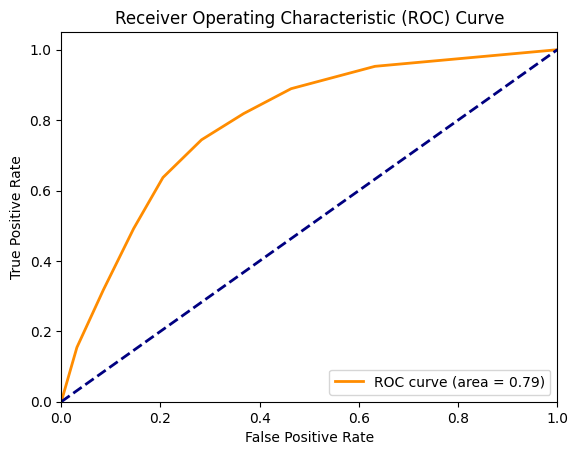

In [55]:
y_test_prob_KNN_model = KNN.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob_KNN_model)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **GaussianNB**

In [56]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train_resampled)
y_train_pred_gnb = gnb.predict(X_train_scaled)
y_test_pred_gnb = gnb.predict(X_test_scaled)
y_test_prob_gnb = KNN.predict_proba(X_test_scaled)[:, 1]

train_accuracy = accuracy_score(y_train_resampled, y_train_pred_gnb)
test_accuracy = accuracy_score(y_test, y_test_pred_gnb)
roc_auc_gnb = roc_auc_score(y_test, y_test_prob_knn)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"gnb ROC-AUC: {roc_auc_svc:.4f}")
print("gnb Test Set Classification Report:")
print(classification_report(y_test, y_test_pred_gnb))

Training Accuracy: 0.7522
Test Accuracy: 0.6887
gnb ROC-AUC: 0.8346
gnb Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.63      0.75      1556
           1       0.45      0.85      0.59       551

    accuracy                           0.69      2107
   macro avg       0.69      0.74      0.67      2107
weighted avg       0.80      0.69      0.71      2107



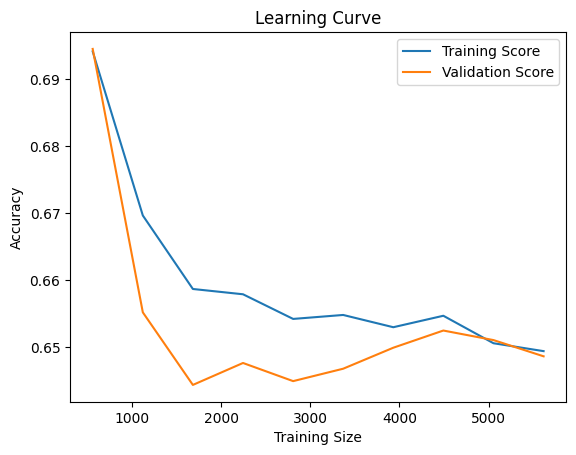

In [57]:
train_sizes, train_scores, test_scores = learning_curve(gnb, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

ROC-AUC Score: 0.8133791563831126


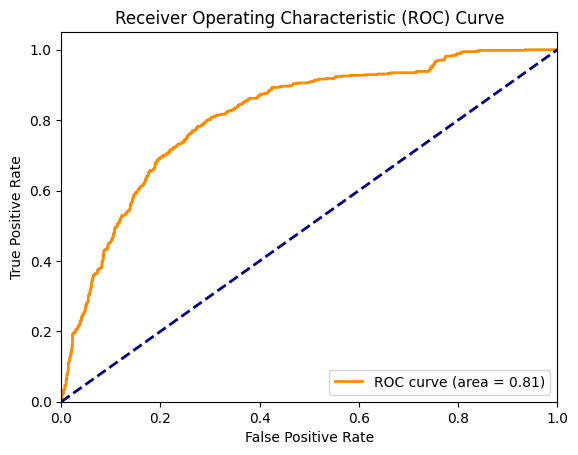

In [58]:
y_test_prob_gnb_model = gnb.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob_gnb_model)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **8. Display accuracy**

In [59]:
import ipywidgets as widgets
from IPython.display import display

# Function to display model accuracies
def display_accuracies():
    # Create text widgets for each model's accuracy
    random_forest_acc = widgets.Text(value=f"RF Test accuracy: {test_accuracy_rf:.2f}", description='RF:', disabled=True)
    logistic_reg_acc = widgets.Text(value=f"LogReg Test accuracy: {test_accuracy_logreg:.2f}", description='LogReg:', disabled=True)
    xgb_acc = widgets.Text(value=f"XGBoost Test accuracy: {test_accuracy_xgb:.2f}", description='XGB:', disabled=True)
    svc_acc = widgets.Text(value=f"SVC Test accuracy: {test_accuracy_SVC:.2f}", description='SVC:', disabled=True)
    knn_acc = widgets.Text(value=f"KNN Test accuracy: {test_accuracy_knn:.2f}", description='KNN:', disabled=True)
    GaussianNB=widgets.Text(value=f"GaussianNB Test accuracy: {test_accuracy:.2f}", description='GaussianNB:', disabled=True)
    # Display widgets in Colab
    display(random_forest_acc)
    display(logistic_reg_acc)
    display(xgb_acc)
    display(svc_acc)
    display(knn_acc)
    display(GaussianNB)

# Call the function to display the accuracies
display_accuracies()


Text(value='RF Test accuracy: 0.79', description='RF:', disabled=True)

Text(value='LogReg Test accuracy: 0.79', description='LogReg:', disabled=True)

Text(value='XGBoost Test accuracy: 0.78', description='XGB:', disabled=True)

Text(value='SVC Test accuracy: 0.79', description='SVC:', disabled=True)

Text(value='KNN Test accuracy: 0.75', description='KNN:', disabled=True)

Text(value='GaussianNB Test accuracy: 0.69', description='GaussianNB:', disabled=True)

# ***Unsupervised Models and Data preprocessing***

In [60]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

In [61]:
new_data = pd.read_csv('Telecom Customers Churn.csv')
new_data.drop(['customerID','TotalCharges'], axis=1)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,Yes


In [62]:
from sklearn.preprocessing import StandardScaler
numerical_cols = new_data.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
new_data[numerical_cols] = scaler.fit_transform(new_data[numerical_cols])

In [63]:
print(new_data.dtypes)


customerID           object
gender               object
SeniorCitizen       float64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [64]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
categorical_cols = new_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    new_data[col] = label_encoder.fit_transform(new_data[col])

In [65]:
new_data.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,-0.439916,1,0,-1.277445,0,1,0,0,...,0,0,0,0,0,1,2,-1.160323,2505,0
1,3962,1,-0.439916,0,0,0.066327,1,0,0,2,...,2,0,0,0,1,0,3,-0.259629,1466,0
2,2564,1,-0.439916,0,0,-1.236724,1,0,0,2,...,0,0,0,0,0,1,3,-0.362660,157,1
3,5535,1,-0.439916,0,0,0.514251,0,1,0,2,...,2,2,0,0,1,0,0,-0.746535,1400,0
4,6511,0,-0.439916,0,0,-1.236724,1,0,1,0,...,0,0,0,0,0,1,2,0.197365,925,1
5,6551,0,-0.439916,0,0,-0.992402,1,2,1,0,...,2,0,2,2,0,1,2,1.159546,6104,1
6,1002,1,-0.439916,0,1,-0.422317,1,2,1,0,...,0,0,2,0,0,1,1,0.808907,1550,0
7,4770,0,-0.439916,0,0,-0.910961,0,1,0,2,...,0,0,0,0,0,0,3,-1.163647,2609,0
8,5604,0,-0.439916,1,0,-0.177995,1,2,1,0,...,2,2,2,2,0,1,2,1.330711,2646,1
9,4534,1,-0.439916,0,1,1.206498,1,0,0,2,...,0,0,0,0,1,0,0,-0.286218,3022,0


In [66]:
X_Data = new_data.drop("Churn", axis = 1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_Data)

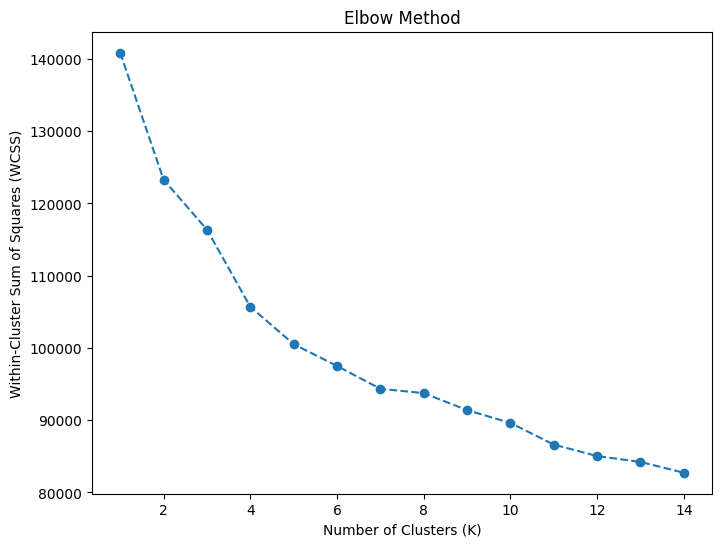

In [67]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()

In [68]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state= 42)
clusters = kmeans.fit_predict(scaled_data)

new_data['Cluster'] = clusters

In [69]:
silhouette_avg = silhouette_score(scaled_data, clusters)
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.13


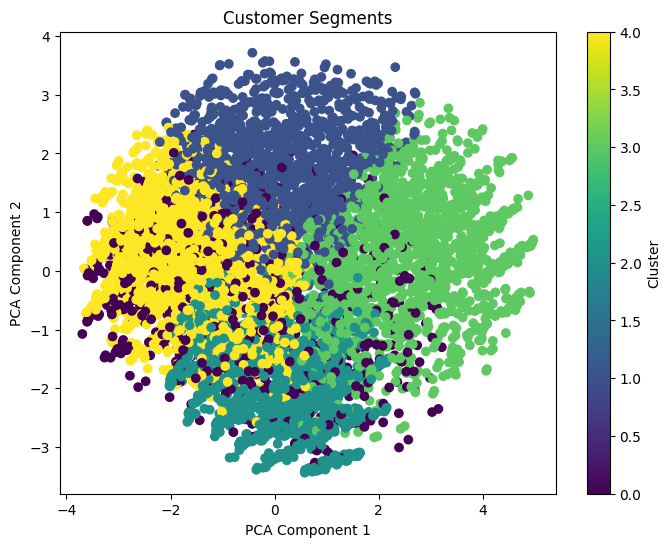

In [70]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

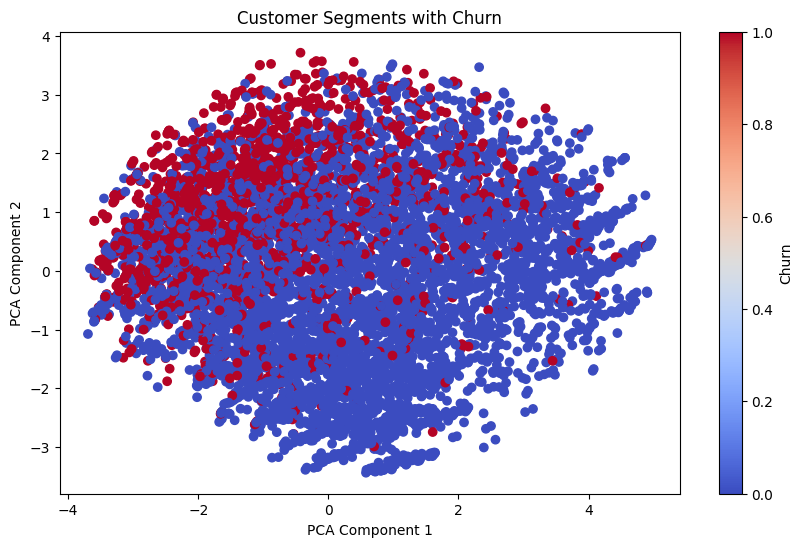

In [71]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=new_data['Churn'], cmap='coolwarm', marker='o')
plt.title('Customer Segments with Churn')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Churn')
plt.show()

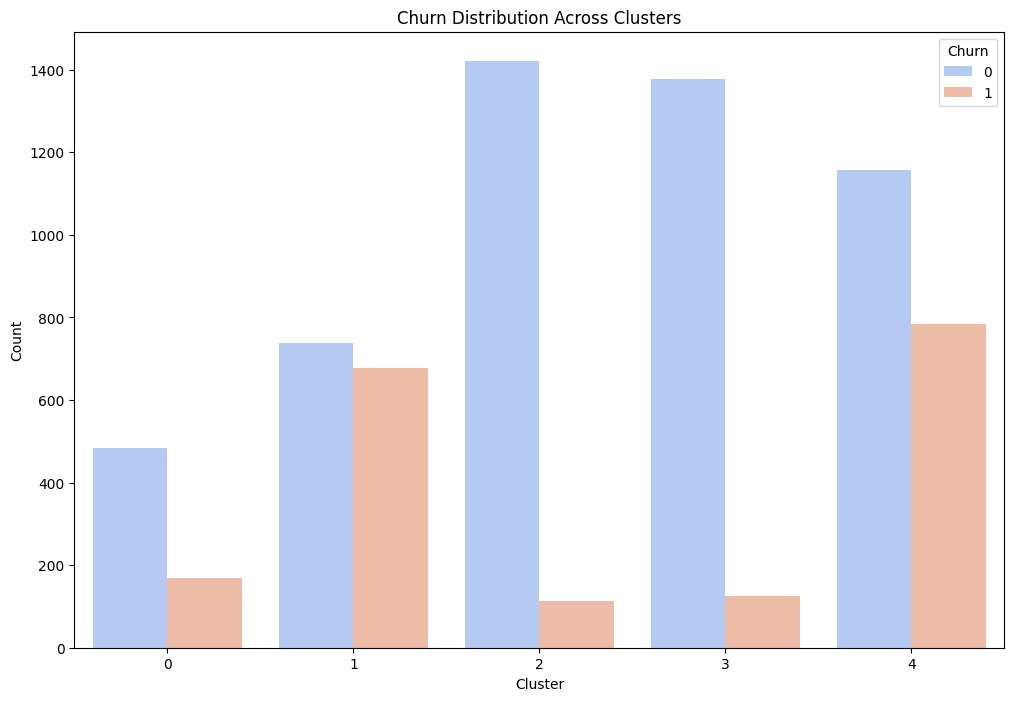

In [72]:
plt.figure(figsize=(12, 8))
sns.countplot(data=new_data, x='Cluster', hue='Churn', palette='coolwarm')
plt.title('Churn Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Churn')
plt.show()

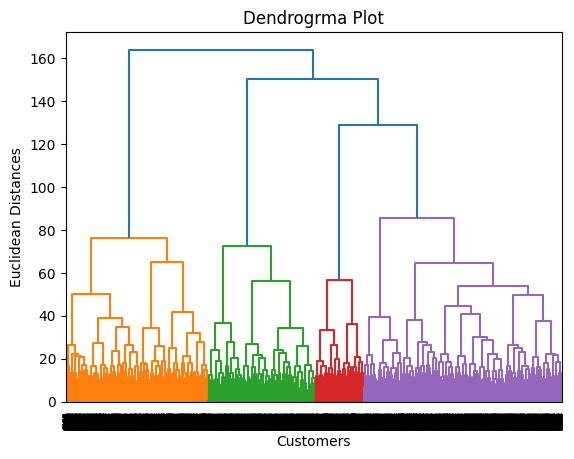

In [73]:
import scipy.cluster.hierarchy as shc
dendro = shc.dendrogram(shc.linkage(scaled_data, method="ward"))
plt.title("Dendrogrma Plot")
plt.ylabel("Euclidean Distances")
plt.xlabel("Customers")
plt.show()

In [74]:
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
hc= AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
clusters_agg = hc.fit_predict(scaled_data)

new_data['Cluster_Agg'] = clusters_agg

In [75]:
silhouette_avg_agg = silhouette_score(scaled_data, clusters_agg)
print(f'Silhouette Score (Agglomerative): {silhouette_avg_agg:.2f}')

Silhouette Score (Agglomerative): 0.11


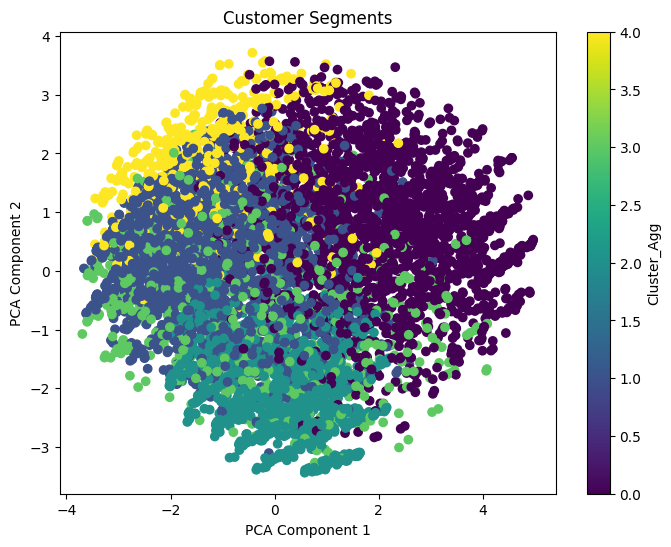

In [76]:
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters_agg, cmap='viridis', marker='o')
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster_Agg')
plt.show()

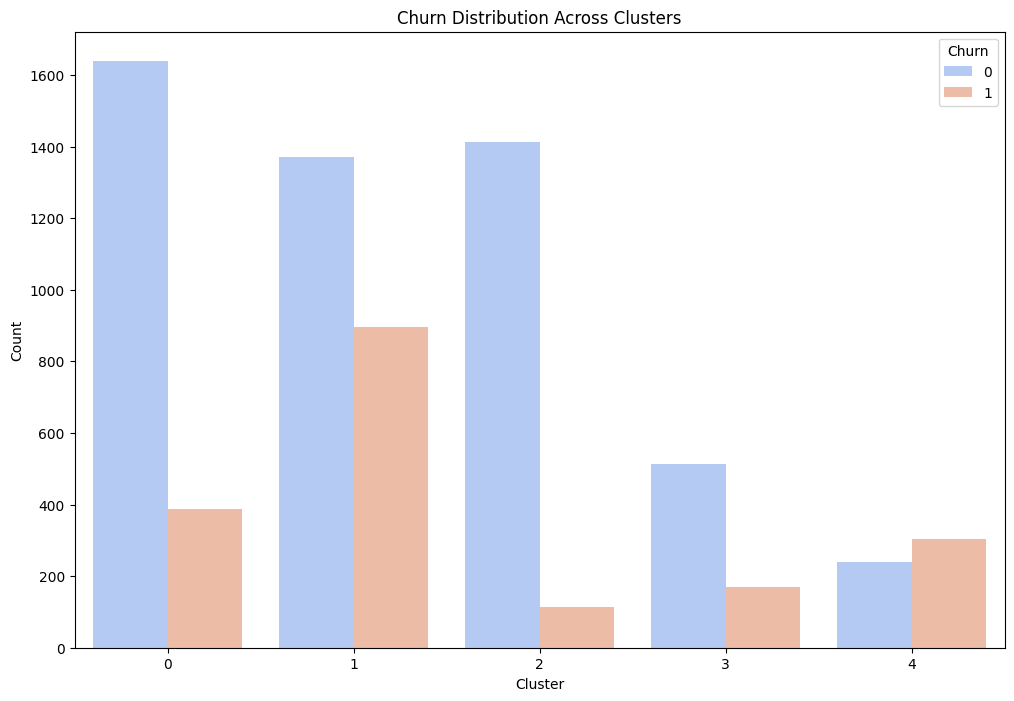

In [77]:
plt.figure(figsize=(12, 8))
sns.countplot(data=new_data, x='Cluster_Agg', hue='Churn', palette='coolwarm')
plt.title('Churn Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Churn')
plt.show()

In [78]:
cluster_summary = new_data.groupby('Cluster').mean()
print("\nCluster Characteristics:")
print(cluster_summary)

# Actionable Insights
for cluster_id in cluster_summary.index:
    print(f"\nCluster {cluster_id}:")
    print(f"  Average Values: {cluster_summary.loc[cluster_id]}")
    print("  Recommendations:")
    if cluster_id == 0:
        print("    - Focus on retention strategies for this segment.")
    elif cluster_id == 1:
        print("    - Offer personalized marketing to increase engagement.")
    elif cluster_id == 2:
        print("    - Improve customer service responsiveness.")
    elif cluster_id == 3:
        print("    - Create targeted promotions for high-value customers.")
    else:
        print("    - Develop loyalty programs to retain long-term customers.")


Cluster Characteristics:
          customerID    gender  SeniorCitizen   Partner  Dependents    tenure  \
Cluster                                                                         
0        3561.301685  0.511485      -0.024438  0.441041    0.290965 -0.095182   
1        3400.354314  0.497171       0.553982  0.465347    0.155587 -0.104790   
2        3497.304433  0.511082      -0.349716  0.485658    0.424381 -0.073566   
3        3597.823569  0.507989      -0.112975  0.744341    0.432091  1.086017   
4        3554.626804  0.500515      -0.031557  0.305670    0.206186 -0.674237   

         PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
Cluster                                                                ...   
0            0.000000       1.000000         0.000000        0.781011  ...   
1            1.000000       1.449788         0.903112        0.285007  ...   
2            1.000000       0.444589         1.991525        1.001956  ...   
3            0.9

In [79]:
for cluster_id in cluster_summary.index:
    print(f"\nCluster {cluster_id}:")
    avg_monthly_charges = cluster_summary.loc[cluster_id, 'MonthlyCharges']
    avg_tenure = cluster_summary.loc[cluster_id, 'tenure']

    print(f"  Average Monthly Charges: {avg_monthly_charges:.2f}")
    print(f"  Average Tenure: {avg_tenure:.2f} months")

    # actionable insights based on cluster characteristics
    if avg_monthly_charges > 70 and avg_tenure < 12:
        print("  Recommendation: Target this segment with upselling options for premium plans.")
    elif avg_tenure > 24 and avg_monthly_charges < 50:
        print("  Recommendation: Implement a loyalty program to reward long-term customers.")
    elif avg_monthly_charges > 80 and avg_tenure < 24:
        print("  Recommendation: Offer personalized retention deals to reduce churn risk.")
    else:
        print("  Recommendation: General retention strategies for this segment.")


Cluster 0:
  Average Monthly Charges: -0.79
  Average Tenure: -0.10 months
  Recommendation: General retention strategies for this segment.

Cluster 1:
  Average Monthly Charges: 0.94
  Average Tenure: -0.10 months
  Recommendation: General retention strategies for this segment.

Cluster 2:
  Average Monthly Charges: -1.44
  Average Tenure: -0.07 months
  Recommendation: General retention strategies for this segment.

Cluster 3:
  Average Monthly Charges: 0.86
  Average Tenure: 1.09 months
  Recommendation: General retention strategies for this segment.

Cluster 4:
  Average Monthly Charges: 0.06
  Average Tenure: -0.67 months
  Recommendation: General retention strategies for this segment.
